In [1]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import cross_val_score
from IPython.display import Image, display_svg, SVG
import matplotlib.pyplot as plt
import joblib
import numpy as np

# Experiment 1 vs. legacy
# 1.0.0 (loss = 95)
# 1.0.1 (loss = 71)
# 1.0.2 (loss = 68)
# 1.0.3 (loss = 90) (range: -10,000 - 10,000)

# Experiment 2 vs. legacy-1 (accurate item price readings)
# 1.0.4 (loss = 142000, loss / mean_pred = 2.76) (range: -1000 - 1500) (dep_var = weighted_profit)

# Experiment 3 - (1.0.5 vs 1.1.0) (weighted_profit vs gst)
# 1.0.5 - (dep_var = weighted_profit) (range: [-400, 700]) (loss = 92000, loss / mean_pred = 2.06)
# 1.1.0 - (dep_var = gst) (range: [-400, 700]) (loss = 54, loss / mean_pred = 1.74)
# 1.1.0 wins

# Experiment 4 - (1.1.1 vs 1.2.0) (gst RF vs. gst NN)
# 1.1.1 - (dep_var = gst) (range: [-400, 700]) (loss = 70, loss / mean_pred = 1.43)
# 1.2.0 - (dep_var = gst) (range: [-400, 700]) (loss = 77, loss / mean_pred = 1.56)

model_version = '1.2.0'
model_can_be_dumped = True
dep_var = 'gst'
num_epochs = 20
y_range_mod = 0.025
layer_sizes = [200, 100]
validation_lookback = 7
train_start_days_past = 63
wanted_columns = [
    "high_price_1h",
    "high_price_5m",
    "high_volume_1h",
    "high_volume_5m",
    "low_price_1h",
    "low_price_5m",
    "low_volume_1h",
    "low_volume_5m",
    "player_count",
    "timestampElapsed",
    "gst"
  ]

In [2]:
path = Path.cwd()
Path.BASE_PATH = path
dsets_path = path.parent.parent/'fastai/datasets'
path.ls()

(#7) [Path('preprocessed_train_valid.pkl'),Path('models'),Path('random_forest.ipynb'),Path('.ipynb_checkpoints'),Path('decision_tree.ipynb'),Path('xg_boost.ipynb'),Path('neural_net.ipynb')]

In [3]:
df = pd.read_csv(dsets_path/'osrs_trades.csv', low_memory=False)
make_date(df, 'timestamp')
df = add_datepart(df, 'timestamp')

/home/tristan/Documents/dev/gpu_env/lib/python3.12/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)


In [4]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def drop_unwanted_columns(df, required_columns):
  df = df[required_columns]
  return df

In [5]:
procs = [Categorify, FillMissing, Normalize]
max_day = df["timestampDayofyear"].max()
minCond = (df.timestampDayofyear>(max_day - train_start_days_past)) # day 117 is when I fixed date recording on completed_trades
maxCond = (df.timestampDayofyear<=(max_day - validation_lookback))
train_idx = np.where((maxCond) & (minCond))[0]
valid_idx = np.where(~maxCond)[0]

df = drop_unwanted_columns(df, wanted_columns)
df = df.sort_index(axis=1)

splits = (list(train_idx),list(valid_idx))
cont,cat = cont_cat_split(df, max_card=9000, dep_var=dep_var)

In [6]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
save_pickle(path/'preprocessed_train_valid.pkl', to)
to = load_pickle(path/'preprocessed_train_valid.pkl')

/home/tristan/Documents/dev/gpu_env/lib/python3.12/site-packages/fastai/learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=de

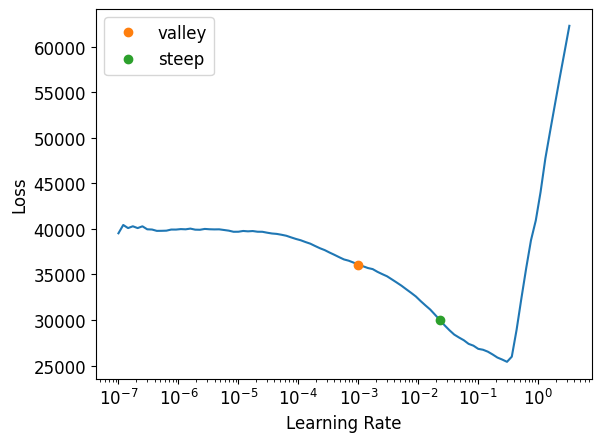

In [7]:
dls = to.dataloaders(1024)
xs,y = to.train.xs,to.train.y
min_y = y.min() - (y_range_mod * y.min())
max_y = y.max() + (y_range_mod * y.max())
learn = tabular_learner(dls, y_range=(min_y, max_y), layers=layer_sizes,
                        n_out=1, loss_func=F.mse_loss)
valley, steep = learn.lr_find(suggest_funcs=(valley, steep))

In [8]:
learn.fit_one_cycle(num_epochs, steep)

epoch,train_loss,valid_loss,time
0,35169.242188,31089.498047,00:00
1,30844.474609,36936.742188,00:00
2,27849.556641,20816.048828,00:00
3,24466.257812,12030.584961,00:00
4,21430.722656,8667.411133,00:00
5,19183.117188,6819.218750,00:00
6,17490.925781,7899.015137,00:00
7,15961.068359,7124.211914,00:00
8,14719.224609,7620.134766,00:00
9,13723.748047,6908.247070,00:00


In [9]:
valid_xs,valid_y = to.valid.xs,to.valid.y

preds, targs = learn.get_preds()
rmse = r_mse(preds, targs)
rmse, rmse / valid_y.mean()

(77.050996, 1.562097244537868)

In [10]:
if model_can_be_dumped:
    learn.export(f'/home/tristan/Documents/dev/ge_bot/prediction_api/{model_version}.pkl')
    print("dumped new model")
else:
    print("did not dump new model")

dumped new model
